In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt

import os as os

import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pltbook import plot_contour_row, container, setup_map


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def add_fhour(ds):

        filename = ds.encoding["source"].split("_")

        init_time = int(filename[-2])
        fhour     = int(filename[-1][-5:-3])

        ds.coords['fhour'] = fhour
        ds.coords['init_time'] = init_time

        return ds
    
def open_mfdataset_list(run_dir, pattern, model_type):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(run_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def read_wrf(run_dir, pattern, model_type):
        
    #ds   = open_mfdataset_list(run_dir, pattern, model_type)
    
    ds   = xr.open_dataset(os.path.join(run_dir,pattern))

    if model_type == 'mpas':
        
        data = {
                'w':   ds.w.values,
                'u':   ds.u.values,
                'v':   ds.v.values,
                't':  ds.theta.values,
                'qv':  1000*ds.qv.values,
                'ref': ds.refl10cm.values,
               }
       
    else:
        data = {
                'w': 0.5*(ds.W.values[:,1:,:,:] + ds.W.values[:,:-1,:,:]),
                'u': 0.5*(ds.U.values[:,:,:,1:] + ds.U.values[:,:,:,:-1]),
                'v': 0.5*(ds.V.values[:,:,1:,:] + ds.V.values[:,:,:-1,:]),
                't': ds.T.values,
                'qv':  1000*ds.QVAPOR.values,
                'ref': ds.REFL_10CM.values,
                'lats': ds.XLAT.values,
                'lons': ds.XLONG.values,
               }
    ds.close()
    
    return data
    

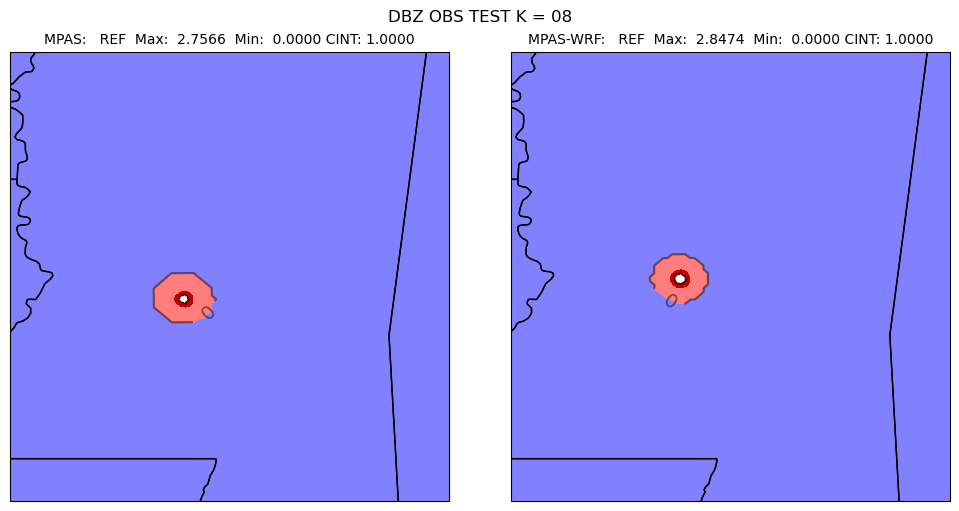

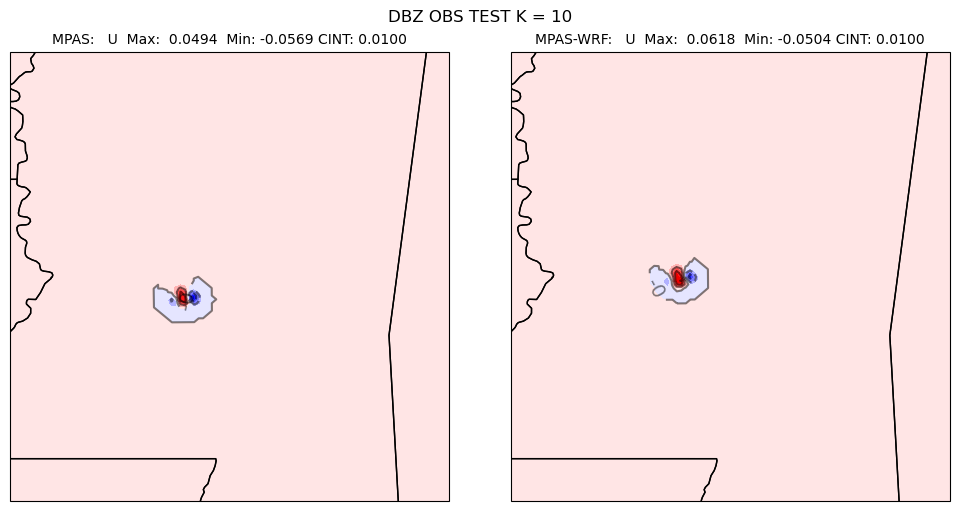

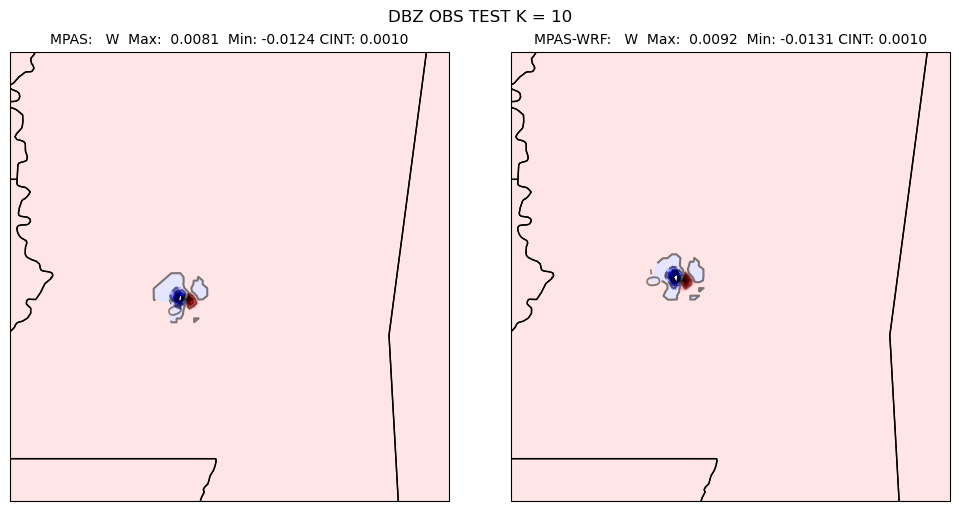

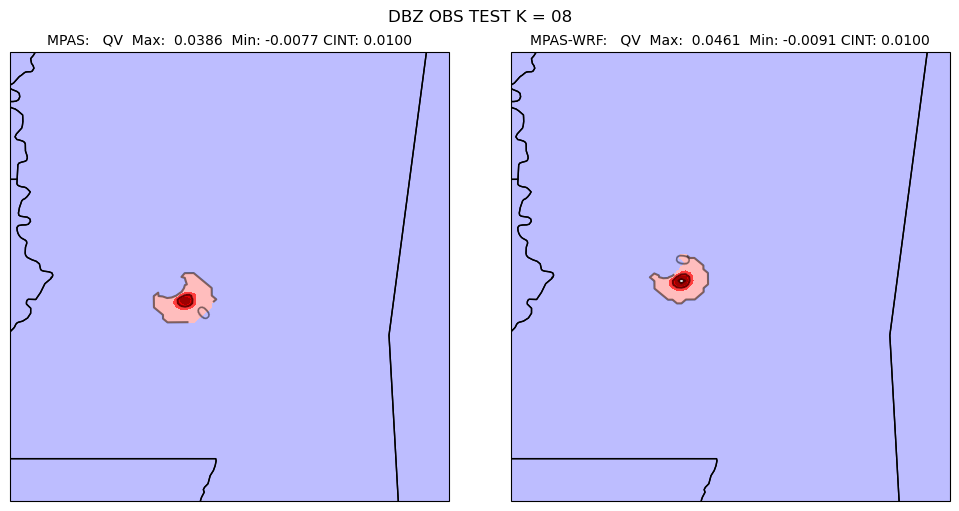

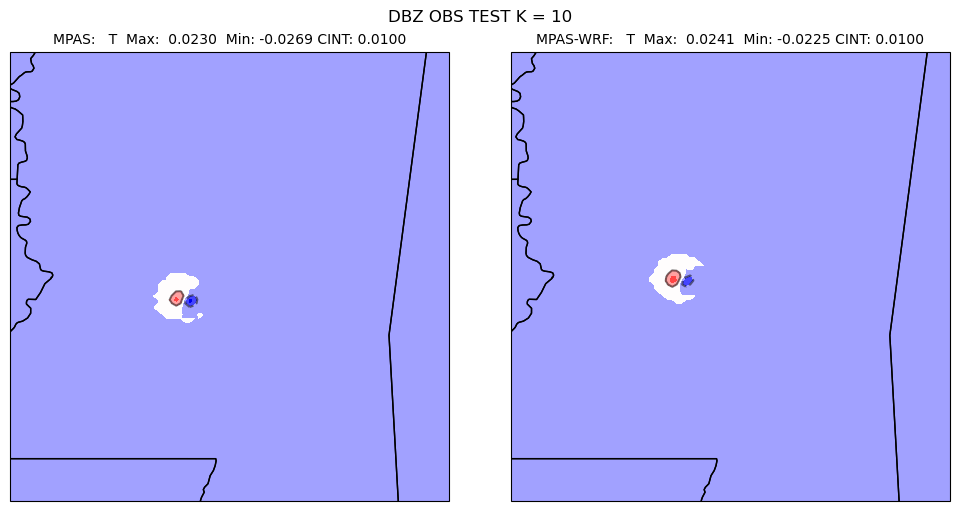

In [95]:
# Single obs test

mpas = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpas_diff_mean_single.nc', 'mpas')
mpaswrf = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpaswrf_mean_diff_single.nc', 'wrf')

extent = [mpaswrf['lons'].min()+3.0,mpaswrf['lons'].max()-4.0,mpaswrf['lats'].min()+3,mpaswrf['lats'].max()-2]

vars    = ['ref', 'u', 'w', 'qv', 't']
cints   = [1, 0.01, 0.001, 0.01, 0.01]
climits = [[-2,2], [-.1,.1], [-.01,.01], [-.04,.04], [-.05,.05]]
fmasks  = [0.1, 0.5, 0.05, 0.25, 0.25]
klevels = [8, 10, 10, 8, 10]

for var, cint, climit, klevel in zip(vars, cints, climits, klevels):
    
    fig, ax = setup_map(2, extent=extent)

    model2 = container(mpas[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])
 
    model3 = container(mpaswrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    plot_contour_row([model2, model3], levels=0, ptitle=['MPAS', 'MPAS-WRF'], suptitle='DBZ OBS TEST K = %2.2i' %(klevel), var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

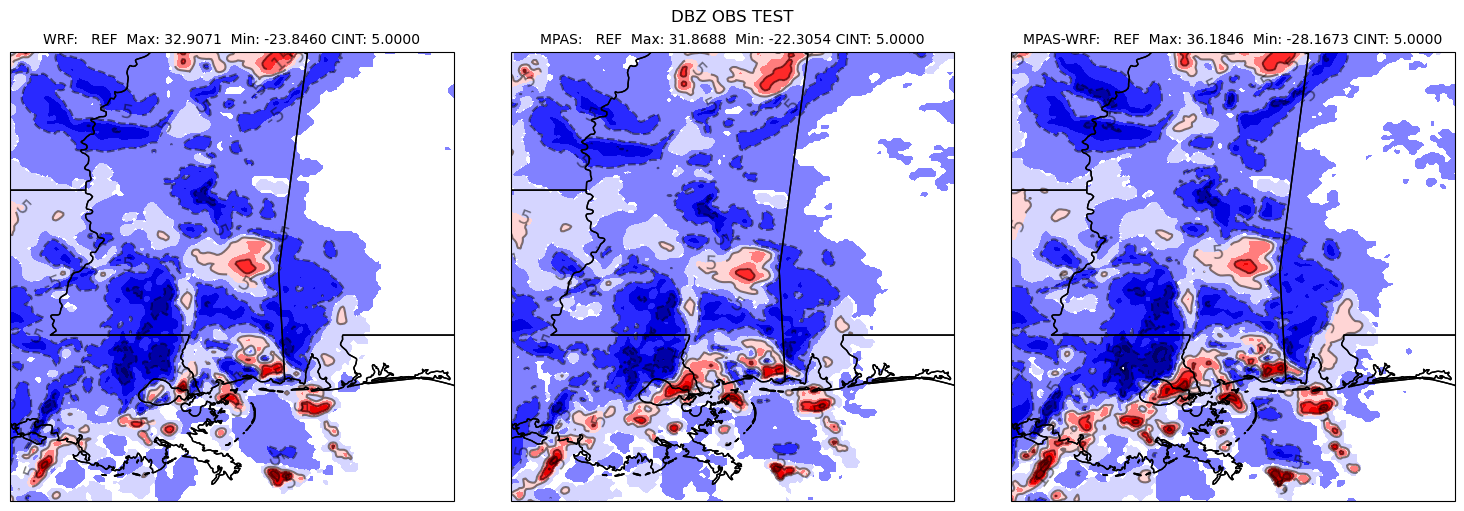

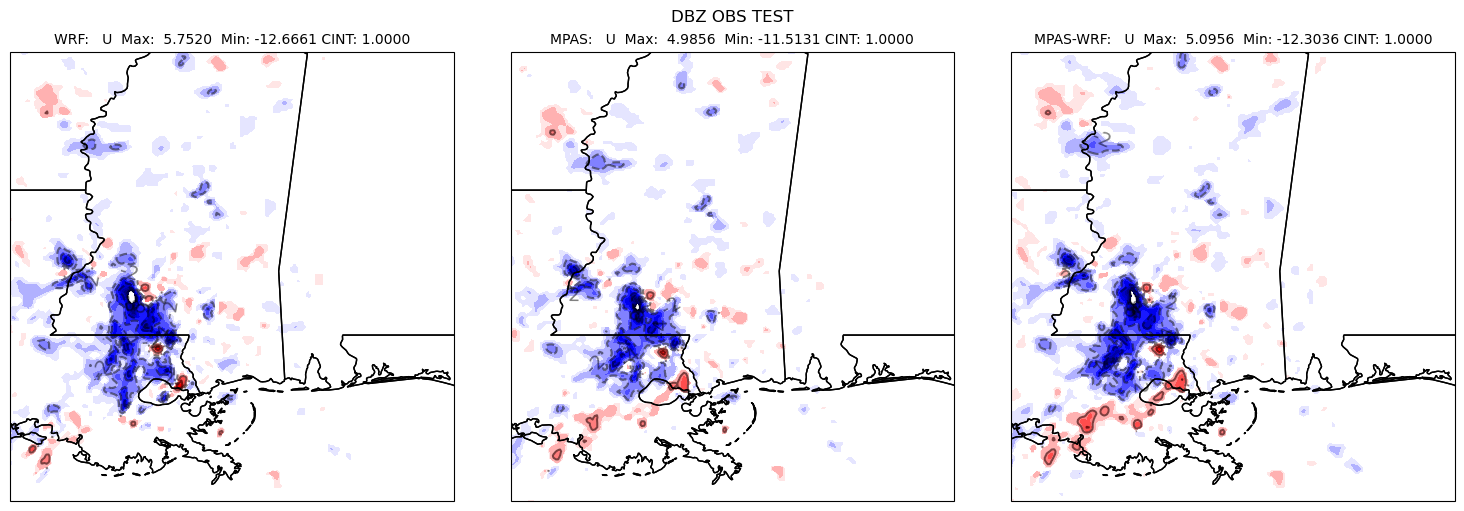

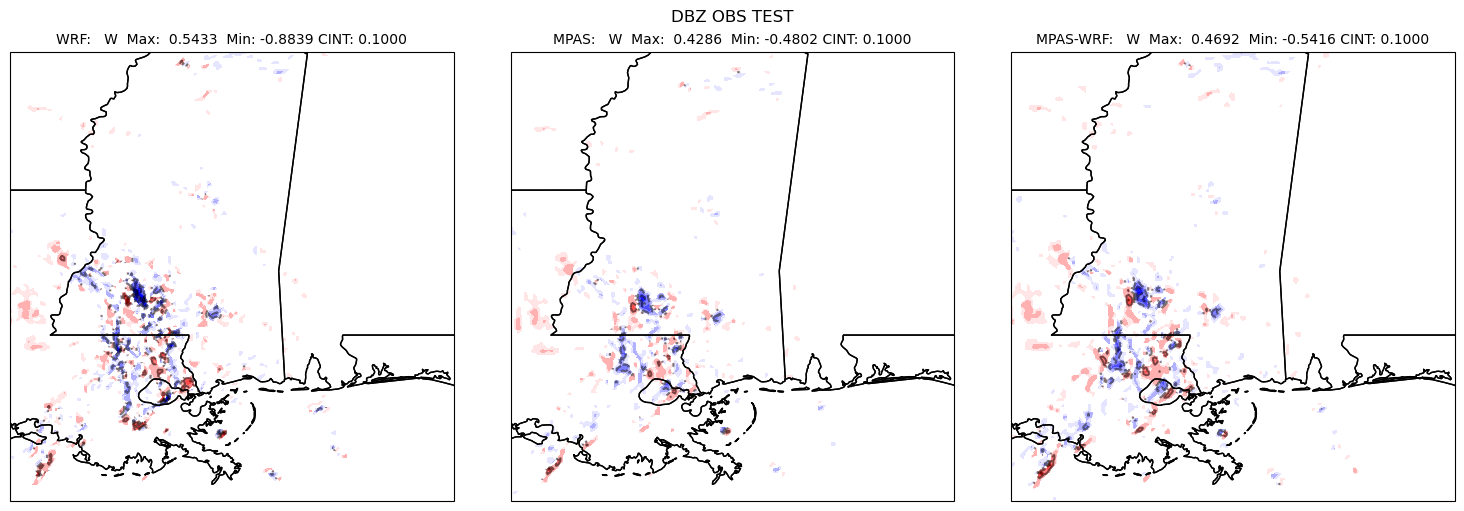

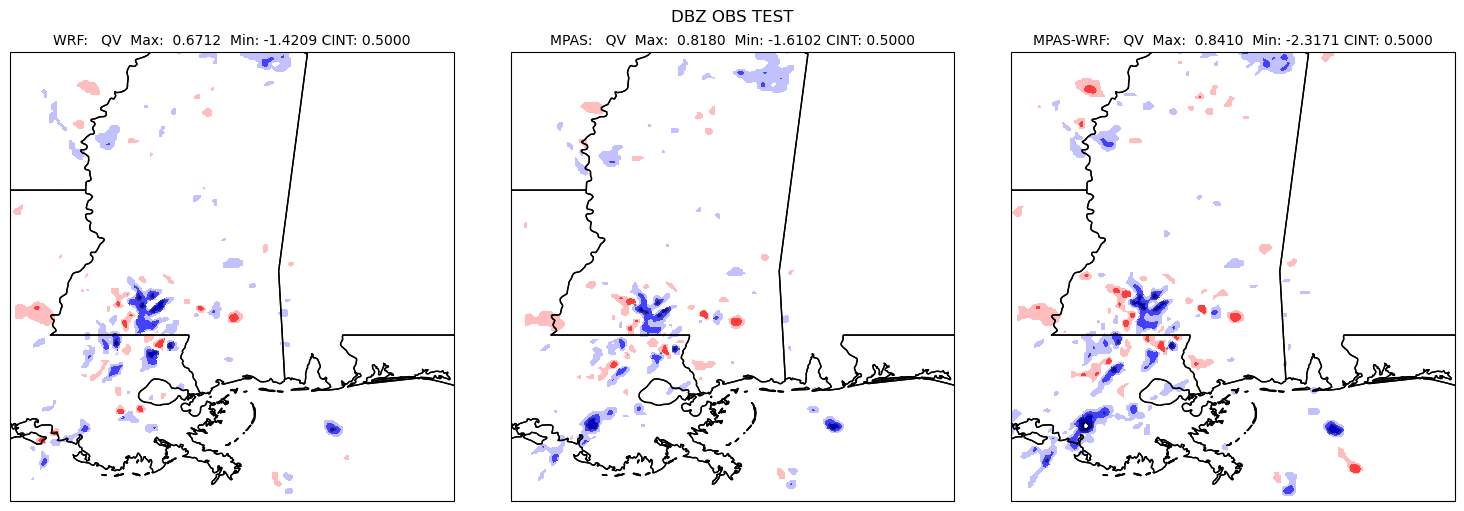

In [76]:
# DBZ only

mpas    = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpas_diff_mean_dbz.nc', 'mpas')
mpaswrf = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpaswrf_mean_diff_dbz.nc', 'wrf')
wrf     = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'wrf_mean_diff_dbz.nc', 'wrf')

extent = [mpaswrf['lons'].min()+2.0,mpaswrf['lons'].max()-2.0,mpaswrf['lats'].min()+1,mpaswrf['lats'].max()-1]

vars    = ['ref', 'u', 'w', 'qv']
cints   = [5, 1, 0.1, 0.5]
climits = [[-25, 35], [-10,10], [-1,1], [-2,2]]
fmasks  = [0.1, 0.5, 0.05, 0.25]


for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(3, extent=extent)

    klevel = 10

    model2 = container(mpas[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])
 
    model3 = container(mpaswrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    model1 = container(wrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    plot_contour_row([model1, model2, model3], levels=0, ptitle=['WRF', 'MPAS', 'MPAS-WRF'], suptitle='DBZ OBS TEST', var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

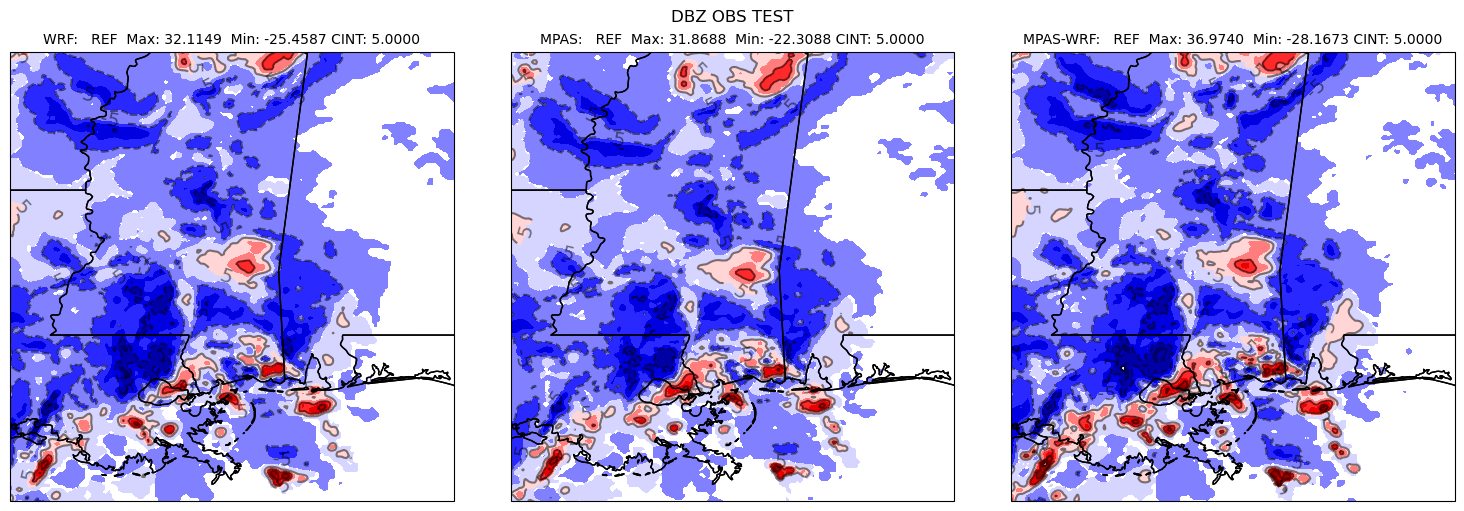

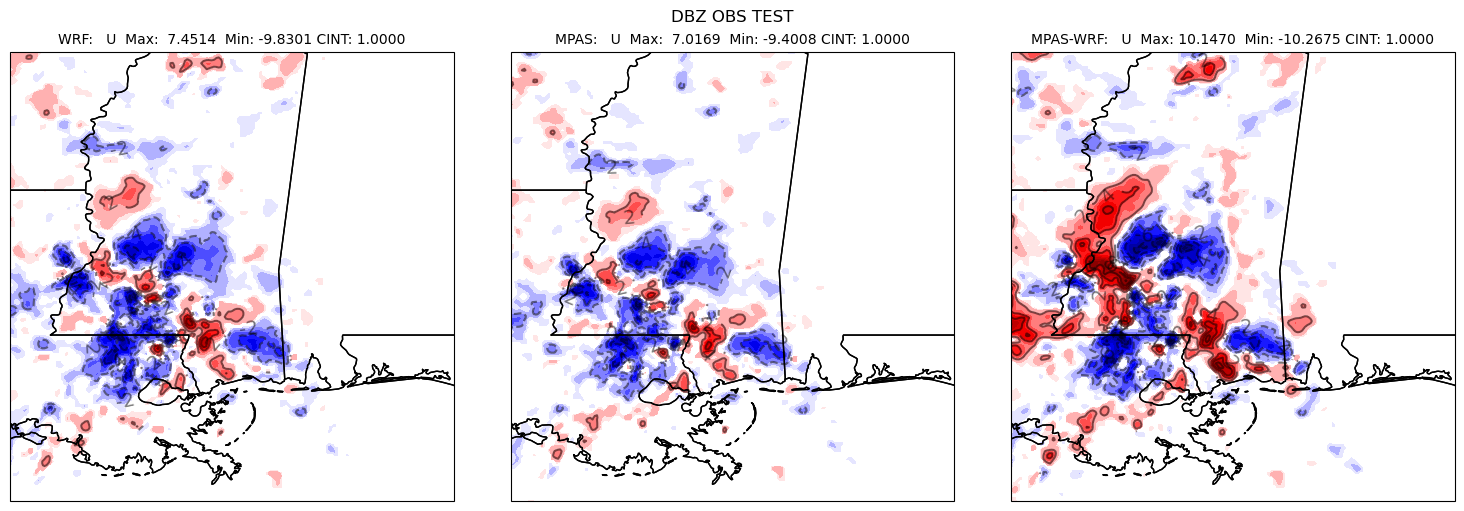

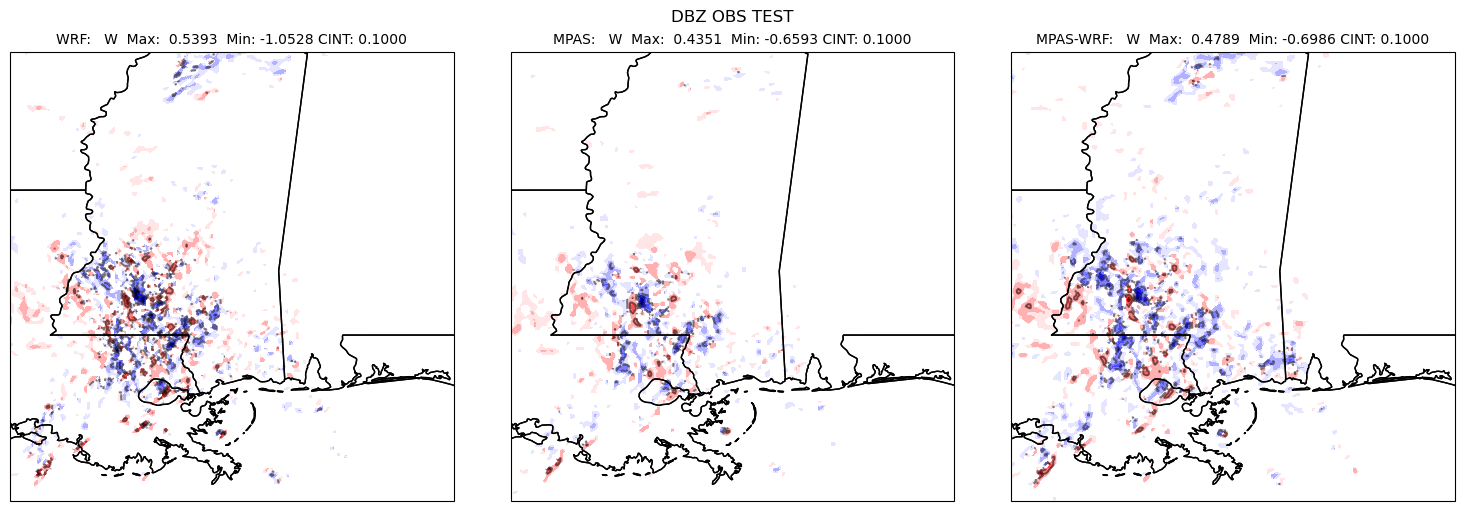

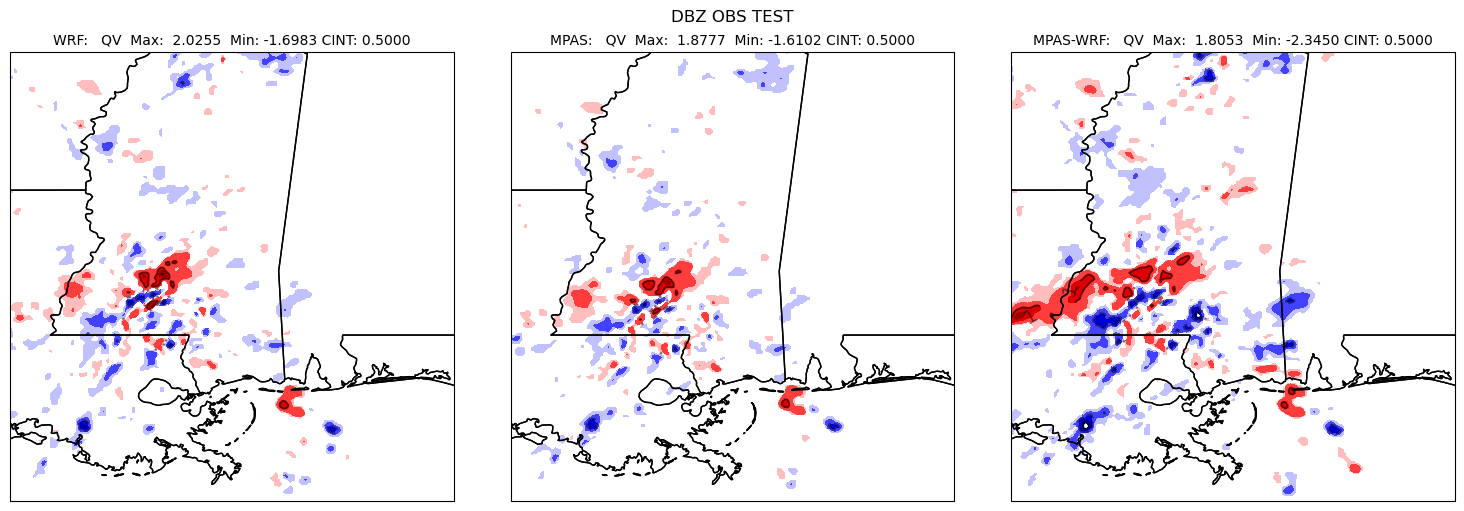

In [75]:
# DBZ+VR only

mpas    = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpas_diff_mean_dbzvr.nc', 'mpas')
mpaswrf = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpaswrf_mean_diff_dbzvr.nc', 'wrf')
wrf     = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'wrf_mean_diff_dbzvr.nc', 'wrf')

extent = [mpaswrf['lons'].min()+2.0,mpaswrf['lons'].max()-2.0,mpaswrf['lats'].min()+1,mpaswrf['lats'].max()-1]

vars    = ['ref', 'u', 'w', 'qv']
cints   = [5, 1, 0.1, 0.5]
climits = [[-25, 35], [-10,10], [-1,1], [-2,2]]
fmasks  = [0.1, 0.5, 0.05, 0.25]


for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(3, extent=extent)

    klevel = 10

    model2 = container(mpas[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])
 
    model3 = container(mpaswrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    model1 = container(wrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    plot_contour_row([model1, model2, model3], levels=0, ptitle=['WRF', 'MPAS', 'MPAS-WRF'], suptitle='DBZ OBS TEST', var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());